<a href="https://colab.research.google.com/github/pratyushethz-star/Pytorch_Tutorials/blob/main/1_D_conduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [52]:
#Create a Model Class that inherits nn.Module
class PINN_Model(nn.Module):
  # Input Layer ( 4 Features of Flower ) -->
  #Hidden Layer1 (Number of Neurons) -->
  #H2 (n) -->
  #Output (Three Class of IRIS)
  def __init__(self,in_features=1,h1=20,h2=20,h3=20,out_features=1):
    super().__init__() #Initiate our nn.Module
    self.fc1 = nn.Linear(in_features,h1)
    self.fc2 = nn.Linear(h1,h2)
    self.fc3 = nn.Linear(h2,h3)
    self.out = nn.Linear(h3,out_features)

  '''
  def forward(self,x):
    x = F.tanh(self.fc1(x))
    x = F.tanh(self.fc2(x))
    x = F.tanh(self.fc3(x))
    x = self.out(x)
  '''
  def forward(self,x):
    self.activation = nn.Tanh()
    x = self.activation(self.fc1(x))
    x = self.activation(self.fc2(x))
    x = self.activation(self.fc3(x))
    x = self.out(x)
    return x


In [53]:
model = PINN_Model()

In [54]:
# 1. Define the input tensor
x = torch.tensor(3.0)

x = x.clone().detach().requires_grad_(True)
# 2. Define the output tensor
#y = x**2 + 2
y = x**3 + 2
# y = 3^2 + 2 = 11

# 3. Compute the gradient (dy/dx = 2x)
# For scalar outputs, grad_outputs can be omitted or set to torch.tensor(1.0)
gradients = torch.autograd.grad(
    outputs=y,
    inputs=x,
    grad_outputs=torch.tensor(y) # Optional for scalar output
)

# gradients is a tuple containing the gradient w.r.t. x
# dy/dx at x=3 is 2 * 3 = 6.0
print(gradients[0])
# Output: (tensor(6.),)

# NOTE: x.grad is NOT populated/mutated:
# print(x.grad)
# Output: None

tensor(783.)


/tmp/ipython-input-810903466.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grad_outputs=torch.tensor(y) # Optional for scalar output


In [55]:
# Function to compute the PDE residual: u''(x) + pi^2 * u(x) = 0
def pde_residual(model, x):
    # Make sure x is set to require gradients for derivative calculations.
    x = x.clone().detach().requires_grad_(True)
    u = model(x)

    # Compute the first derivative, du/dx.
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Compute the second derivative, d^2u/dx^2.
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    # Calculate the residual of the PDE.
    residual = u_xx + (torch.pi**2) * u
    return residual

1. We use requires_grad_(True) to tell PyTorch that we need to compute derivatives with respect to x.
2. The torch.autograd.grad function computes first and second derivatives.
3. The PDE residual (or physics loss) is the difference uxx ​+ π²u, which should be zero.

In [56]:
# Set up the optimizer and training parameters.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Create collocation points for the interior of the domain where the ODE is enforced.
x_collocation = torch.linspace(0, 1, 100).view(-1, 1)

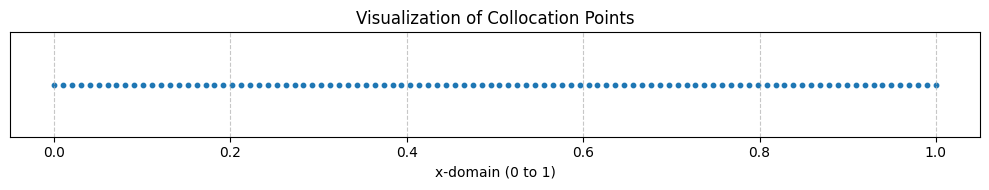

In [57]:
# Convert to a numpy array for plotting
x_np = x_collocation.cpu().numpy().flatten()
y_np = torch.zeros_like(x_collocation).cpu().numpy().flatten()

# Plot the points
plt.figure(figsize=(10, 2))
plt.scatter(x_np, y_np, s=10) # s is the size of the marker

plt.title('Visualization of Collocation Points')
plt.xlabel('x-domain (0 to 1)')
plt.yticks([]) # Hide y-axis since it's just a 1D line of points
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('collocation_points_plot.png')

**The loss function is a combination of three components:**
  *   Physics Loss: Ensures the ODE is satisfied.
  *   Boundary Loss: Enforces u(0) = 0 and u(1) = 0.
  *   Interior Loss: Forces the non-trivial condition, for example u(0.5) = 1.


In [58]:
# Define boundary points and their known values.
x_boundary = torch.tensor([[0.0], [1.0]], dtype=torch.float32)
u_boundary = torch.zeros_like(x_boundary)

# Define an interior data point to guide the solution away from zero: u(0.5)=1.
x_interior = torch.tensor([[0.5]], dtype=torch.float32)
u_interior = torch.tensor([[1.0]], dtype=torch.float32)

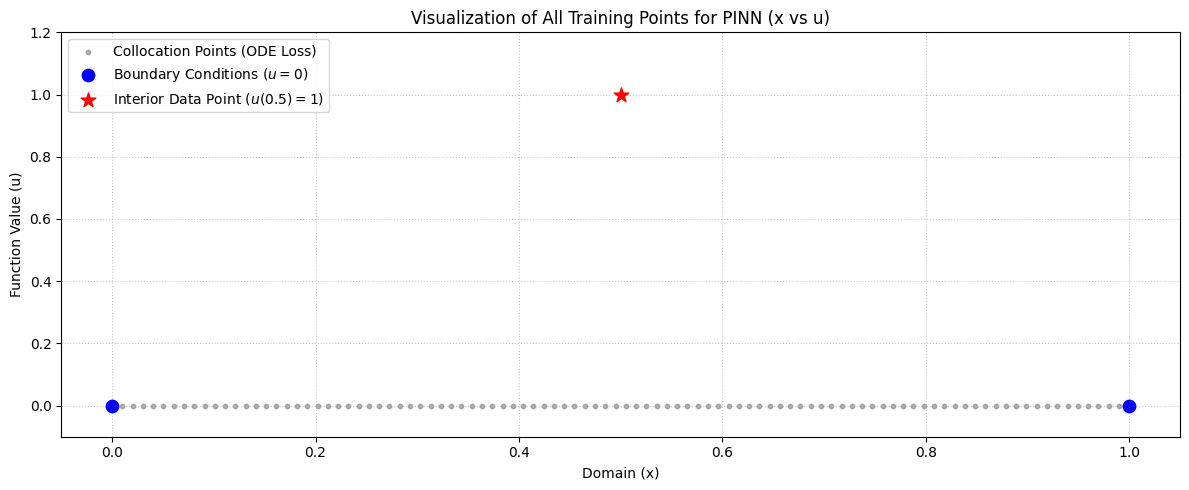

In [32]:
# --- Prepare data for Matplotlib (convert to NumPy arrays) ---
x_all_np = x_collocation.cpu().numpy().flatten()
x_bc_np = x_boundary.cpu().numpy().flatten()
x_int_np = x_interior.cpu().numpy().flatten()
u_int_np = u_interior.cpu().numpy().flatten()
u_bc_np = u_boundary.cpu().numpy().flatten()

# Create the plot
plt.figure(figsize=(12, 5))

# 1. Plot the Collocation Points (ODE Enforcement points)
# These points define the domain where the physics loss (ODE) is enforced.
# We plot them at u=0 for visualization, but they have no 'u' target.
plt.scatter(x_all_np, np.zeros_like(x_all_np),
            s=10, color='gray', label='Collocation Points (ODE Loss)', alpha=0.6)

# 2. Plot the Boundary Condition (BC) Points (Data Loss)
plt.scatter(x_bc_np, u_bc_np,
            s=80, color='blue', marker='o', label='Boundary Conditions ($u=0$)', zorder=5)

# 3. Plot the Interior Data Point (Data Loss)
plt.scatter(x_int_np, u_int_np,
            s=120, color='red', marker='*', label='Interior Data Point ($u(0.5)=1$)', zorder=5)

# --- Formatting ---
plt.title('Visualization of All Training Points for PINN (x vs u)')
plt.xlabel('Domain (x)')
plt.ylabel('Function Value (u)')
plt.ylim(-0.1, 1.2)
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show() # Display the plot

In [59]:
#Train our Model
#Epochs ? (One run thru all the training data in our Network)
epochs=5000
losses = []
for i in range(epochs):

    # Compute the physics loss on collocation points.
    res = pde_residual(model, x_collocation)
    loss_physics = torch.mean(res**2)

    # Compute the boundary loss for u(0)=0 and u(1)=0.
    u_pred_boundary = model(x_boundary)
    loss_boundary = torch.mean((u_pred_boundary - u_boundary)**2)

    # Compute the interior loss to enforce u(0.5)=1.
    u_pred_interior = model(x_interior)
    loss_interior = torch.mean((u_pred_interior - u_interior)**2)

    # Total loss is the sum of all individual losses.
    loss = loss_physics + loss_boundary + loss_interior

    #Keep trac of our losses
    losses.append(loss.detach().numpy())

    # print every 10 epoch
    if i % 500 == 0:
        print(f'Epoch: {i} Loss: {loss}')

    #Do some back propagation: take the error rate of forward propagation
    #and feed it back thru the network to fine tune the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print("Training complete!")

Epoch: 0 Loss: 3.989603042602539
Epoch: 500 Loss: 0.3413969576358795
Epoch: 1000 Loss: 0.0007073191809467971
Epoch: 1500 Loss: 0.005227813497185707
Epoch: 2000 Loss: 6.693872273899615e-05
Epoch: 2500 Loss: 4.495576649787836e-05
Epoch: 3000 Loss: 3.9069716876838356e-05
Epoch: 3500 Loss: 3.3529551728861406e-05
Epoch: 4000 Loss: 3.0289695132523775e-05
Epoch: 4500 Loss: 2.784105708997231e-05
Training complete!


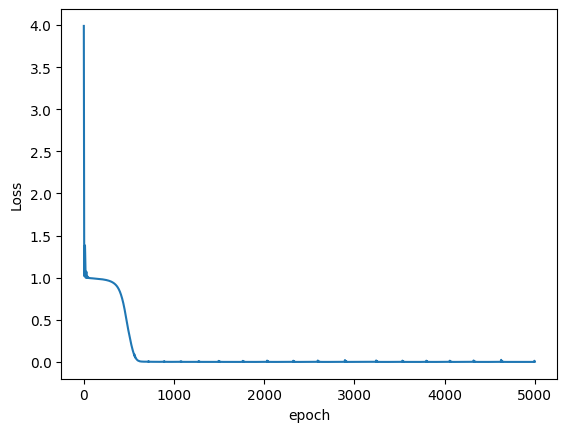

In [60]:
# Graph it out!
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

Shape of model output tensor: torch.Size([100, 1])


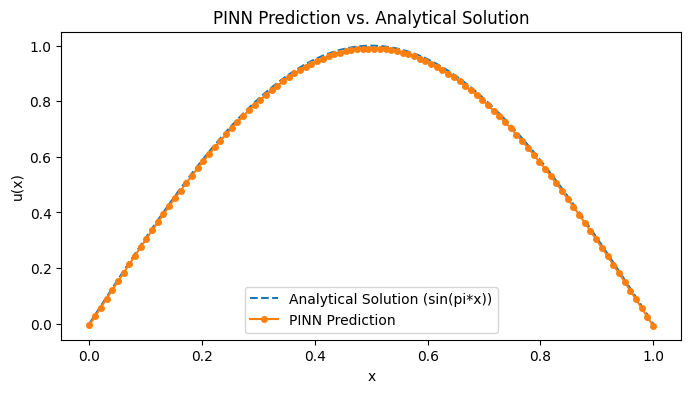

In [61]:

# Evaluate the trained model over the domain [0, 1].
x_test = torch.linspace(0, 1, 100).view(-1, 1)
'''
with torch.no_grad():
    u_pred = model(x_test).numpy().flatten()
'''
with torch.no_grad():
    u_pred_tensor = model(x_test)
    print(f"Shape of model output tensor: {u_pred_tensor.shape}") # Should be (100, 1) or (100,)
    u_pred = u_pred_tensor.numpy().flatten()

# Compute the analytical solution: u(x) = sin(pi * x)
x_np = x_test.numpy().flatten()
u_true = np.sin(np.pi * x_np)

# Plot the PINN prediction vs. the analytical solution.
plt.figure(figsize=(8, 4))
plt.plot(x_np, u_true, label='Analytical Solution (sin(pi*x))', linestyle='dashed')
plt.plot(x_np, u_pred, label='PINN Prediction', marker='o', markersize=4)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('PINN Prediction vs. Analytical Solution')
plt.show()